In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot
import requests
import re

In [2]:
fileURL = './crime_data_zip.csv'
crime_data = pd.read_csv(fileURL, header=0)

In [3]:
crime_data = crime_data.dropna(how="any")

indexNames = crime_data[ crime_data['DISTRICT'] == '0' ].index
# Delete these row indexes from dataFrame
crime_data.drop(indexNames , inplace=True)

indexNames2 = crime_data[ crime_data['DISTRICT'] == 0 ].index
# Delete these row indexes from dataFrame
crime_data.drop(indexNames2 , inplace=True)

crime_data.head(15)

,INCIDENT_NUMBER,OFFENSE_CODE,OFFENSE_CODE_GROUP,OFFENSE_DESCRIPTION,DISTRICT,REPORTING_AREA,SHOOTING,OCCURRED_ON_DATE,YEAR,MONTH,DAY_OF_WEEK,HOUR,UCR_PART,STREET,Lat,Long,Location,RANGE,PERIOD,ZIP
0,I192050013,2403,Disorderly Conduct,DISTURBING THE PEACE,C11,341,0,2019-06-30,2019,6,Sunday,23,Part Two,BOWDOIN ST,42.305740,-71.067624,"(42.30573977, -71.06762362)",2018-2019,2019-6,2121
1,I192050013,2405,Disorderly Conduct,DISORDERLY CONDUCT,C11,341,0,2019-06-30,2019,6,Sunday,23,Part Two,BOWDOIN ST,42.305740,-71.067624,"(42.30573977, -71.06762362)",2018-2019,2019-6,2121
2,I192050019,3503,Missing Person Located,MISSING PERSON - NOT REPORTED - LOCATED,B2,319,0,2019-06-30,2019,6,Sunday,23,Part Three,CHENEY ST,42.309700,-71.085824,"(42.30970016, -71.08582414)",2018-2019,2019-6,2121
3,I192050009,3115,Investigate Person,INVESTIGATE PERSON,B3,418,0,2019-06-30,2019,6,Sunday,23,Part Three,FULLER ST,42.280093,-71.080054,"(42.28009279, -71.08005410)",2018-2019,2019-6,2124
4,I192050004,3501,Missing Person Reported,MISSING PERSON,C6,175,0,2019-06-30,2019,6,Sunday,23,Part Three,SOUTHAMPTON ST,42.332108,-71.070144,"(42.33210843, -71.07014395)",2018-2019,2019-6,2118
5,I192050006,3001,Medical Assistance,DEATH INVESTIGATION,A1,111,0,2019-06-30,2019,6,Sunday,23,Part Three,WASHINGTON ST,42.353581,-71.062367,"(42.35358129, -71.06236665)",2018-2019,2019-6,2112
6,I192050006,3007,Medical Assistance,SUDDEN DEATH,A1,111,0,2019-06-30,2019,6,Sunday,23,Part Three,WASHINGTON ST,42.353581,-71.062367,"(42.35358129, -71.06236665)",2018-2019,2019-6,2112
7,I192052344,619,Larceny,LARCENY ALL OTHERS,D4,624,0,2019-06-30,2019,6,Sunday,22,Part One,LANSDOWNE ST,42.347174,-71.096444,"(42.34717363, -71.09644390)",2018-2019,2019-6,2115
8,I192050000,3410,Towed,TOWED MOTOR VEHICLE,D4,594,0,2019-06-30,2019,6,Sunday,22,Part Three,MASSACHUSETTS AVE,42.341870,-71.083722,"(42.34186952, -71.08372190)",2018-2019,2019-6,2118
9,I192049998,2610,Other,TRESPASSING,A1,102,0,2019-06-30,2019,6,Sunday,22,Part Two,WESLEYAN PL,42.356617,-71.060605,"(42.35661726, -71.06060465)",2018-2019,2019-6,2108


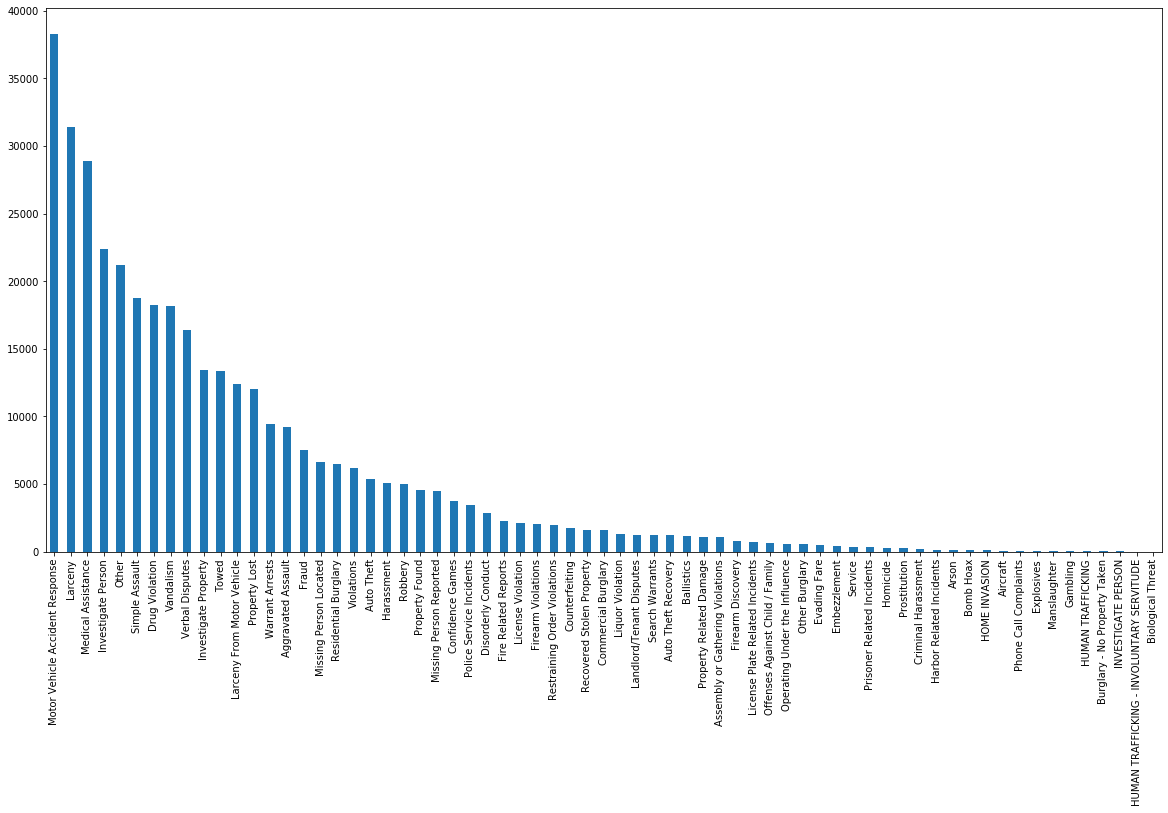

In [4]:
pd.value_counts(crime_data.OFFENSE_CODE_GROUP).plot.bar(figsize=(20,10))

In [5]:
pd.value_counts(crime_data.STREET).head(10)

WASHINGTON ST        17642
BLUE HILL AVE         8856
BOYLSTON ST           8604
DORCHESTER AVE        6119
TREMONT ST            5902
HARRISON AVE          5624
MASSACHUSETTS AVE     5486
CENTRE ST             5404
COMMONWEALTH AVE      4816
HYDE PARK AVE         4360
Name: STREET, dtype: int64

In [6]:
pd.value_counts(crime_data.SHOOTING)

0    370740
Y      1563
Name: SHOOTING, dtype: int64

In [7]:
# Year and crime type stats

crime_data.groupby(['OFFENSE_CODE_GROUP','RANGE']).size()

OFFENSE_CODE_GROUP                RANGE    
Aggravated Assault                2015-2016    1346
                                  2016-2017    2200
                                  2017-2018    2277
                                  2018-2019    3386
Aircraft                          2015-2016       4
                                  2016-2017       4
                                  2017-2018      17
                                  2018-2019      20
Arson                             2015-2016      11
                                  2016-2017      33
                                  2017-2018      31
                                  2018-2019      29
Assembly or Gathering Violations  2015-2016     236
                                  2016-2017     314
                                  2017-2018     232
                                  2018-2019     265
Auto Theft                        2015-2016     933
                                  2016-2017    1401
                    

In [8]:
# Filtering part one crimes and then getting its stats

part_one_crime = crime_data[crime_data.UCR_PART == 'Part One']
part_one_crime.groupby(['OFFENSE_CODE_GROUP','RANGE']).size()

OFFENSE_CODE_GROUP          RANGE    
Aggravated Assault          2015-2016     1346
                            2016-2017     2200
                            2017-2018     2277
                            2018-2019     3386
Auto Theft                  2015-2016      933
                            2016-2017     1401
                            2017-2018     1305
                            2018-2019     1753
Commercial Burglary         2015-2016      261
                            2016-2017      425
                            2017-2018      427
                            2018-2019      460
Homicide                    2015-2016       40
                            2016-2017       54
                            2017-2018       62
                            2018-2019       96
Larceny                     2015-2016     4934
                            2016-2017     7624
                            2017-2018     7565
                            2018-2019    11306
Larceny From Motor Veh

In [9]:
# Crime data of Part One crimes based on streets

part_one_crime.groupby(['OFFENSE_CODE_GROUP','RANGE','STREET']).size()

OFFENSE_CODE_GROUP  RANGE      STREET                  
Aggravated Assault  2015-2016   ALBANY ST                   2
                                COMMONWEALTH AVE            1
                               ACADEMY TER                  3
                               ACKLEY PL                    1
                               ADAMS ST                     7
                               ALBANY ST                    2
                               ALBION ST                    1
                               ALDRICH ST                   1
                               ALLSTATE RD                  5
                               ALLSTON ST                   2
                               ALMONT ST                    3
                               ALPHA RD                     3
                               ALPINE ST                    2
                               AMERICAN LEGION HWY          3
                               AMORY ST                     1
              

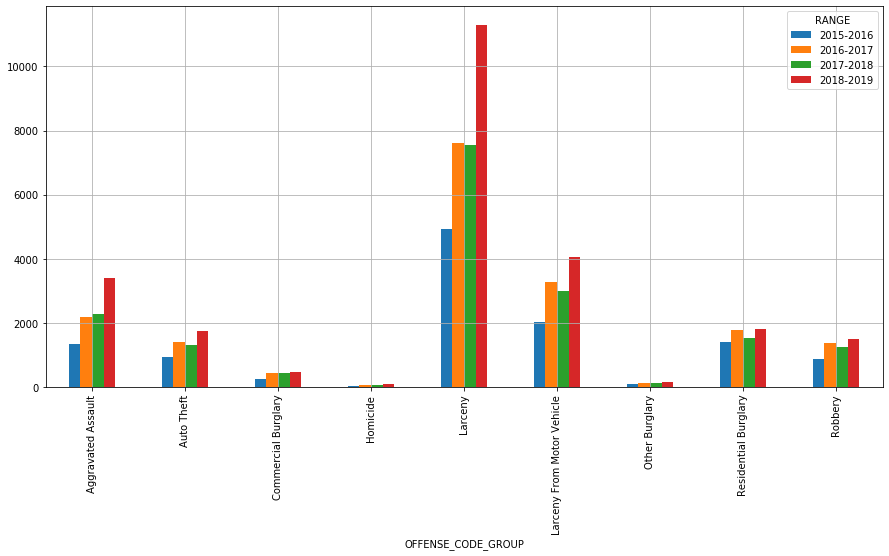

In [10]:
fig, ax = plt.subplots(figsize=(15,7))
part_one_crime.groupby(['OFFENSE_CODE_GROUP','RANGE']).count()['INCIDENT_NUMBER'].unstack().plot.bar(ax=ax, grid='True')

In [11]:
part_one_crime.groupby(['RANGE','STREET']).count()['INCIDENT_NUMBER'].unstack().fillna(0).T

RANGE,2015-2016,2016-2017,2017-2018,2018-2019
STREET,,,,
ALBANY ST,7.0,1.0,0.0,0.0
BLUE HILL AVE,0.0,0.0,1.0,1.0
COMMONWEALTH AVE,1.0,0.0,0.0,0.0
MASSACHUSETTS AVE,2.0,0.0,0.0,0.0
0,0.0,44.0,42.0,42.0
A ST,7.0,9.0,4.0,14.0
ABBOT ST,2.0,5.0,7.0,1.0
ABBOTSFORD ST,2.0,5.0,5.0,6.0
ABERDEEN ST,1.0,3.0,0.0,3.0


In [12]:
def sorted(s, num):
    tmp = s.sort_values(ascending=False)[:num]  # earlier s.order(..)
    tmp.index = range(num)
    return tmp
part_one_crime.groupby(['RANGE','STREET']).count()['INCIDENT_NUMBER'].unstack().fillna(0).T.apply(lambda x: sorted(x, 10))

RANGE,2015-2016,2016-2017,2017-2018,2018-2019
0,636.0,948.0,937.0,1341.0
1,529.0,821.0,825.0,1123.0
2,232.0,410.0,390.0,588.0
3,231.0,361.0,368.0,533.0
4,214.0,339.0,334.0,468.0
5,197.0,327.0,324.0,444.0
6,186.0,315.0,315.0,443.0
7,176.0,284.0,299.0,441.0
8,172.0,275.0,265.0,359.0
9,164.0,265.0,257.0,348.0


In [13]:
# datetime.datetime.strptime("6/30/2019 23:55", '%m/%d/%Y HH:MM').strftime('%m/%d/%y')
# def date_time_conversion(dt):
#     datetime_object = datetime.strptime(dt, '%m/%d/%Y').strftime('%Y-%m-%d')
#     return datetime_object
# crime_data['OCCURRED_ON_DATE'] = crime_data.OCCURRED_ON_DATE.apply(lambda x: date_time_conversion(x))

In [14]:
date_count_data = pd.DataFrame(crime_data.groupby(['OCCURRED_ON_DATE']).count()['INCIDENT_NUMBER'])

E:\Anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
E:\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


Test MSE: 861.104


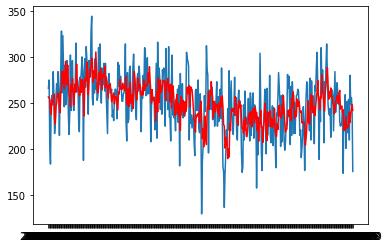

<Figure size 1080x504 with 0 Axes>

In [15]:
train, test = date_count_data[:"2018-04-13"], date_count_data["2018-04-13":]
predictions = list()

for index, row in test.iterrows():
    model = ARIMA(train, order=(6,1,0), freq='D')
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    train.loc[index] = row.INCIDENT_NUMBER
#     print('predicted=%f, expected=%f' % (yhat, row.INCIDENT_NUMBER))
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)
# plot
pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.figure(figsize=(15,7))
pyplot.show()

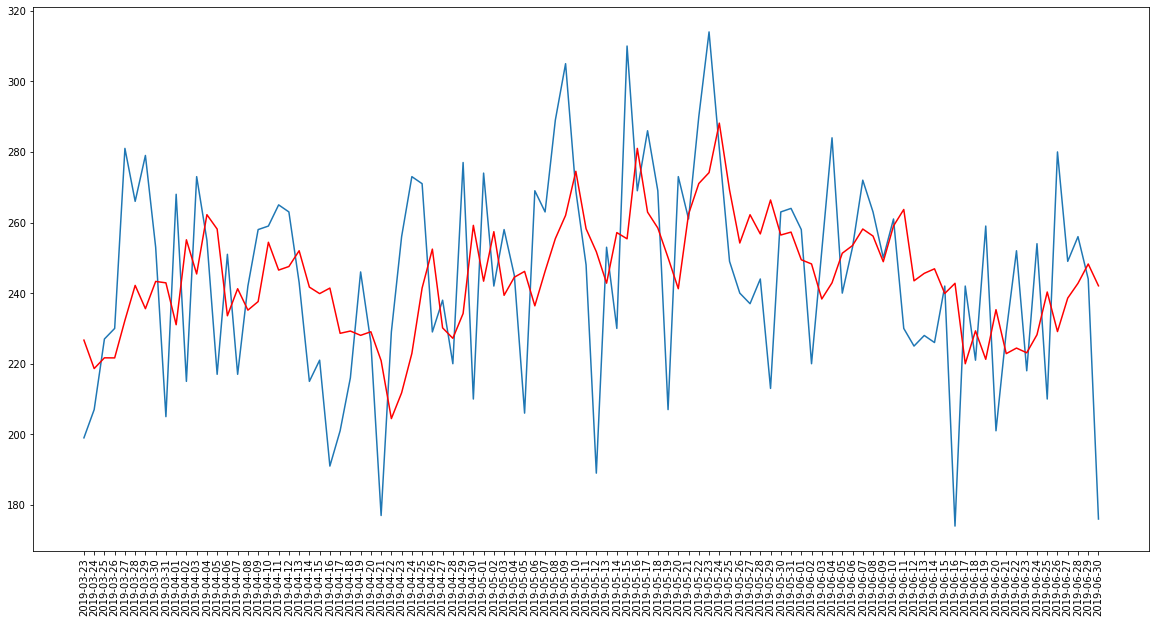

In [16]:
pyplot.figure(figsize=(20,10))
pyplot.plot(test.tail(100))
pyplot.plot(predictions[-100:], color='red')
pyplot.xticks(rotation='vertical')
pyplot.show()

In [17]:
district_date_data = pd.DataFrame(crime_data.groupby(['DISTRICT','OCCURRED_ON_DATE']).count()['INCIDENT_NUMBER'])

In [45]:
# location_to_zip = dict()

In [55]:
# def find_zip_codes(location):
#     location = location.replace('(','')
#     location = location.replace(')','')
#     location = location.replace(' ','')
#     # api-endpoint 
#     URL = "http://open.mapquestapi.com/geocoding/v1/reverse"

#     # defining a params dict for the parameters to be sent to the API 
#     PARAMS = {'key':"0UivSSWlMrR71m5haZ8pJJxWAW4vE3KL",'location':location} 
    
#     if location in location_to_zip:
#         return location_to_zip[location]
    
#     # sending get request and saving the response as response object 
#     r = requests.get(url = URL, params = PARAMS) 

#     # extracting data in json format 
#     data = r.json()
#     location_to_zip[location] = data['results'][0]['locations'][0]['postalCode']
#     return data['results'][0]['locations'][0]['postalCode']

# crime_data['ZIP'] = crime_data.Location.apply(lambda x: find_zip_codes(x))

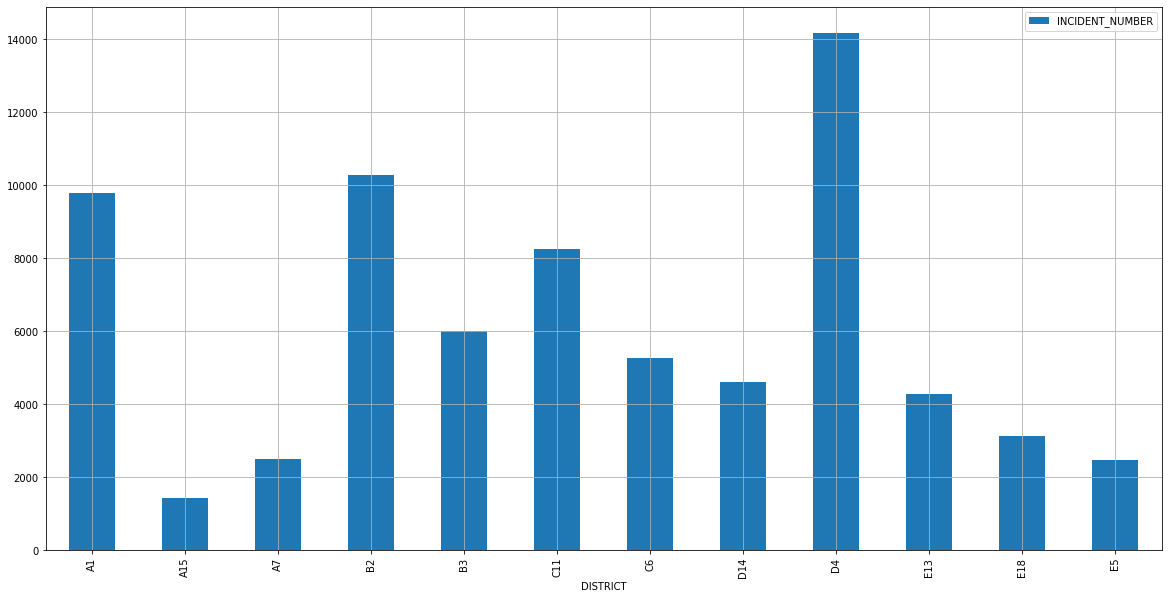

In [24]:
# Plot that shows number of crimes per district.

pd.DataFrame(part_one_crime.groupby(['DISTRICT']).count()['INCIDENT_NUMBER']).plot.bar(figsize=(20,10), grid='true')

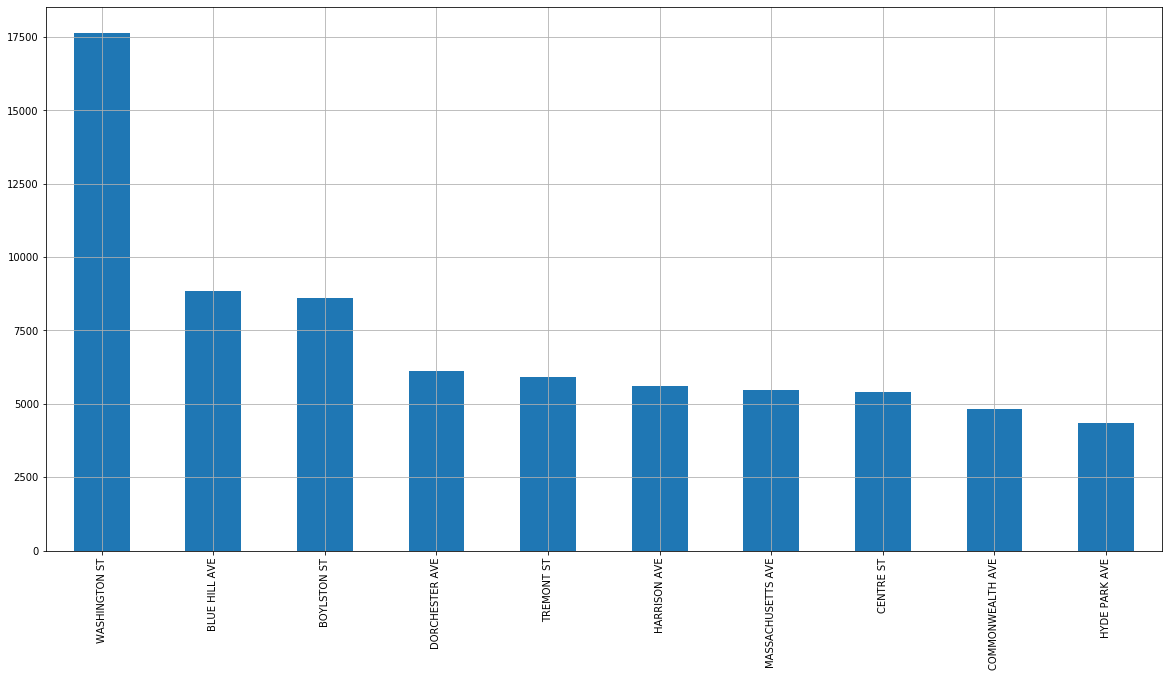

In [23]:
# Top 10 crime infested streets

pd.value_counts(crime_data.STREET).head(10).plot.bar(figsize=(20,10), grid='True')

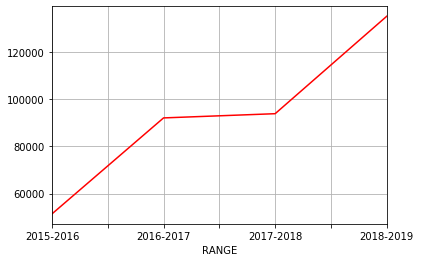

In [28]:
# Overall crime rate over the years from 2015 to 2019.

crime_data.groupby(['RANGE']).count()['INCIDENT_NUMBER'].plot.line(c='r', grid='true')

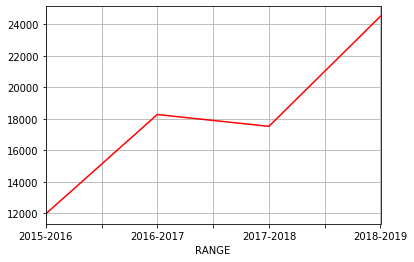

In [29]:
# Only part one crime rate over the years from 2015 to 2019.

part_one_crime.groupby(['RANGE']).count()['INCIDENT_NUMBER'].plot.line(c='r', grid='true')

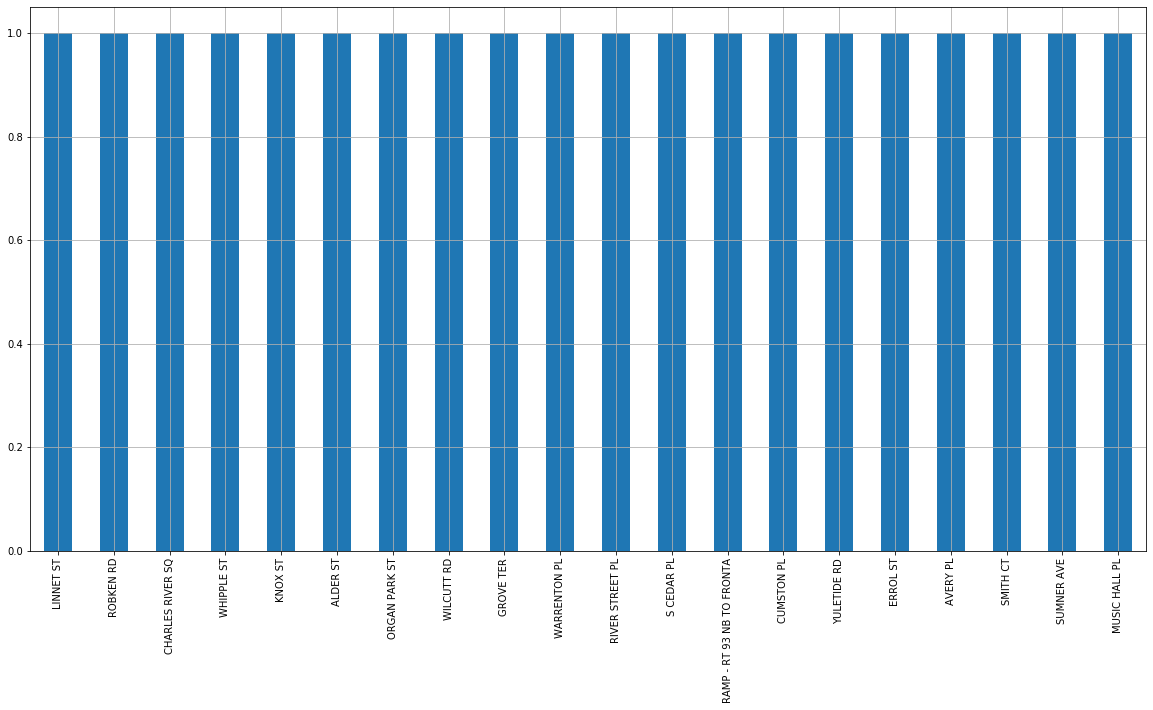

In [31]:
# Top 20 safest streets

pd.value_counts(crime_data.STREET).tail(20).plot.bar(figsize=(20,10), grid='True')